Zbiór danych: https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland?resource=download

Dataset zawiera informacje o nieruchomościach na sprzedaż w Polsce z czerwca 2024r  

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = 'apartments_pl_2024_06.csv'

apartments_data = pd.read_csv(data_path)

num_rows, num_columns = apartments_data.shape

print(f"Liczba rekordów (wierszy): {num_rows}")
print(f"Liczba cech (kolumn): {num_columns}")

pd.set_option('display.max_columns', None)
print(apartments_data.head())

Liczba rekordów (wierszy): 21501
Liczba cech (kolumn): 28
                                 id      city               type  \
0  811891f98a870dfd6e414374a0a85560  szczecin       blockOfFlats   
1  adaf636d0c44d8d9325bce42403eefee  szczecin  apartmentBuilding   
2  9b957bd60885a469c96f17b58a914f4b  szczecin  apartmentBuilding   
3  74fef2ff7135bc70797a3fbfd7d44ed6  szczecin       blockOfFlats   
4  77cc78c75b0d09bf84d6d3124a28803c  szczecin       blockOfFlats   

   squareMeters  rooms  floor  floorCount  buildYear   latitude  longitude  \
0         47.00    2.0    6.0        12.0     1981.0  53.428544  14.552812   
1         88.22    3.0    1.0         2.0     2000.0  53.449093  14.516844   
2        117.00    5.0    4.0         4.0        NaN  53.443096  14.561348   
3         33.31    1.0    1.0         4.0     1963.0  53.436100  14.541200   
4         56.00    3.0    7.0         7.0     2018.0  53.447465  14.557811   

   centreDistance  poiCount  schoolDistance  clinicDistance  \
0

Zbiór zawiera 21501 rekordów, liczba cech w całym zbiorze wynosi 28. Do przeprowadzenia regresji zostaną wykorzystane następujące cechy:

1. squareMeters – metraż mieszkania w metrach kwadratowych
2. city – miasto, w którym znajduje się mieszkanie
3. rooms – liczba pokoi w mieszkaniu
4. floor – piętro, na którym znajduje się lokal
5. floorCount – liczba pięter w całym budynku
6. buildYear – rok budowy nieruchomości
7. latitude – szerokość geograficzna mieszkania
8. longitude – długość geograficzna mieszkania
9. centreDistance – odległość od centrum miasta (w km)
10. poiCount – liczba punktów zainteresowania w pobliżu (np. sklepy, usługi)
11. schoolDistance – odległość do najbliższej szkoły (w km)
12. clinicDistance – odległość do najbliższej przychodni (w km)
13. postOfficeDistance – odległość do najbliższej poczty (w km)
14. kindergartenDistance – odległość do najbliższego przedszkola (w km)
15. restaurantDistance – odległość do najbliższej restauracji (w km)
16. collegeDistance – odległość do najbliższej uczelni wyższej (w km)
17. pharmacyDistance – odległość do najbliższej apteki (w km)
18. hasElevator – czy mieszkanie znajduje się w budynku z windą (tak/nie)
19. hasParkingSpace – czy mieszkanie posiada miejsce parkingowe (tak/nie)
20. hasStorageRoom – czy mieszkanie posiada komórkę lokatorską (tak/nie)
21. hasBalcony – czy mieszkanie posiada balkon (tak/nie)
22. hasSecurity – czy budynek posiada monitoring lub ochronę (tak/nie)
23. type – typ nieruchomości (blockOfFlats, apartmentBuilding, tenement)
24. buildingMaterial – materiał, z którego wykonano budynek (brick, concreteSlab)
25. ownership – forma własności (condominium, cooperative, udział)
26. condition – stan techniczny lokalu (low, standard, premium)
27. price – cena mieszkania w złotych

Zbiór posłuży do przeprowadzenia regresji cen mieszkań, z wykorzystaniem powyższych cech.

In [105]:
selected_columns = [
    'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear',
    'latitude', 'longitude', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance',
    'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
    'pharmacyDistance', 'ownership', 'buildingMaterial', 'condition', 'hasParkingSpace',
    'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom', 'price'
]


missing_values = apartments_data[selected_columns].isnull().sum()

missing_percentage = (missing_values / len(apartments_data) * 100).round(2).astype(str) + "%"

print("Brakujące wartości dla wszystkich cech:")
print(missing_percentage)

Brakujące wartości dla wszystkich cech:
city                      0.0%
type                    20.45%
squareMeters              0.0%
rooms                     0.0%
floor                   16.62%
floorCount               0.97%
buildYear               15.72%
latitude                  0.0%
longitude                 0.0%
centreDistance            0.0%
poiCount                  0.0%
schoolDistance           0.05%
clinicDistance           0.29%
postOfficeDistance       0.09%
kindergartenDistance     0.09%
restaurantDistance       0.14%
collegeDistance          2.72%
pharmacyDistance         0.14%
ownership                 0.0%
buildingMaterial        40.89%
condition               74.05%
hasParkingSpace           0.0%
hasBalcony                0.0%
hasElevator              4.46%
hasSecurity               0.0%
hasStorageRoom            0.0%
price                     0.0%
dtype: object


In [106]:
error_counts = {}

valid_values = {
    "hasElevator": ["yes", "no"],
    "hasParkingSpace": ["yes", "no"],
    "hasStorageRoom": ["yes", "no"],
    "type": ["blockOfFlats", "apartmentBuilding", "tenement"],
    "buildingMaterial": ["brick", "concreteSlab"],
    "hasSecurity": ["yes", "no"],
    "hasBalcony": ["yes", "no"],
    "ownership": ["condominium", "udział","cooperative"],
    "condition": ["premium", "low"]
}

for col, valid in valid_values.items():
    invalid_values = apartments_data[~apartments_data[col].isin(valid)][col].dropna()
    error_counts[col] = len(invalid_values)

invalid_city = apartments_data['city'].isna() | (apartments_data['city'].str.strip() == "")
error_counts["city"] = invalid_city.sum()


valid_ranges = {
    "squareMeters": (10, 500),
    "rooms": (1, 10),
    "floor": (0, 50),
    "floorCount": (1, 50),
    "buildYear": (1800, 2025),
    "centreDistance": (0, 100),
    "poiCount": (0, 500),
    "schoolDistance": (0, 100),
    "clinicDistance": (0, 100),
    "postOfficeDistance": (0, 100),
    "kindergartenDistance": (0, 100),
    "restaurantDistance": (0, 100),
    "collegeDistance": (0, 100),
    "pharmacyDistance": (0, 100),
    "latitude": (-90, 90),
    "longitude": (-180, 180),
    "price": (50000, 5000000)
}

for col, (min_val, max_val) in valid_ranges.items():
    invalid_values = apartments_data[
        (apartments_data[col] < min_val) | (apartments_data[col] > max_val)
    ][col]
    error_counts[col] = len(invalid_values)

total_rows = len(apartments_data)
for col, count in error_counts.items():
    percent = round((count / total_rows) * 100, 2)
    print(f"{col.ljust(20)} {str(count).ljust(5)} ({percent}%)")

hasElevator          0     (0.0%)
hasParkingSpace      0     (0.0%)
hasStorageRoom       0     (0.0%)
type                 0     (0.0%)
buildingMaterial     0     (0.0%)
hasSecurity          0     (0.0%)
hasBalcony           0     (0.0%)
ownership            0     (0.0%)
condition            0     (0.0%)
city                 0     (0.0%)
squareMeters         0     (0.0%)
rooms                0     (0.0%)
floor                0     (0.0%)
floorCount           0     (0.0%)
buildYear            0     (0.0%)
centreDistance       0     (0.0%)
poiCount             0     (0.0%)
schoolDistance       0     (0.0%)
clinicDistance       0     (0.0%)
postOfficeDistance   0     (0.0%)
kindergartenDistance 0     (0.0%)
restaurantDistance   0     (0.0%)
collegeDistance      0     (0.0%)
pharmacyDistance     0     (0.0%)
latitude             0     (0.0%)
longitude            0     (0.0%)
price                0     (0.0%)


Zbiór nie zawiera niepoprawnych wartości.  

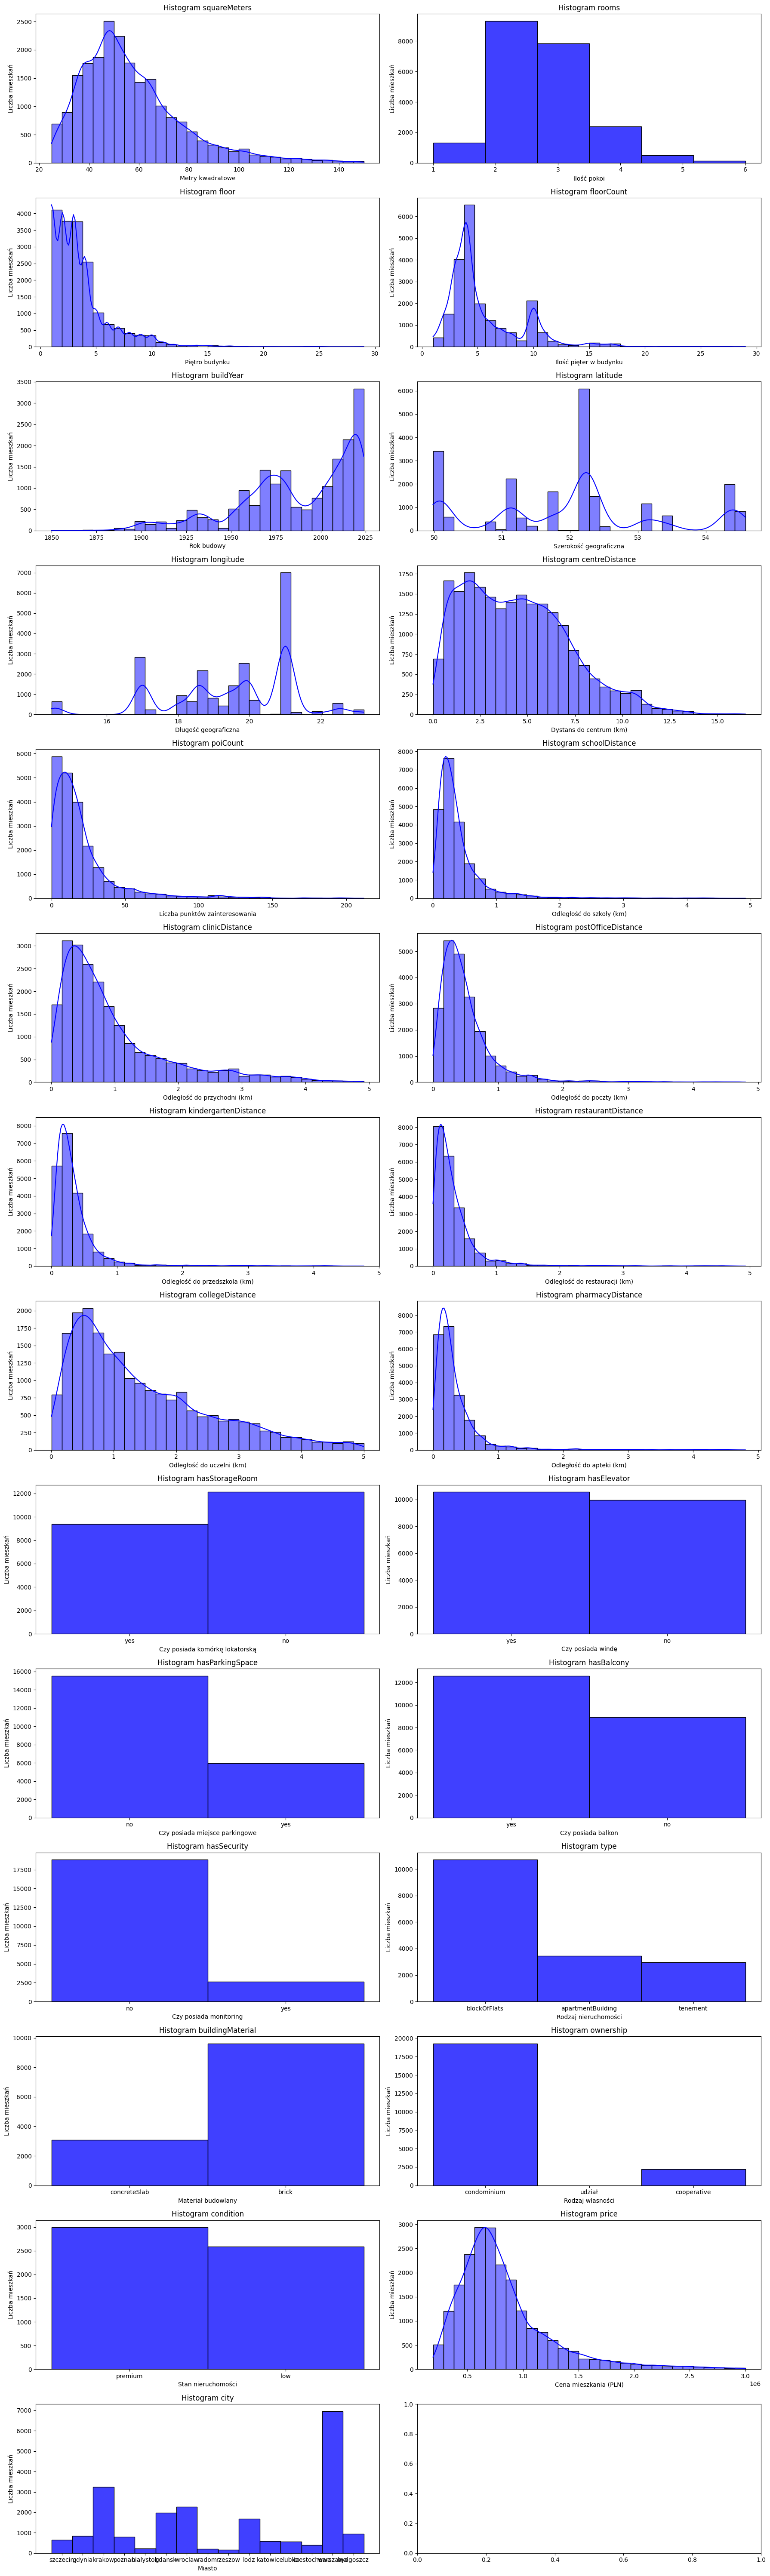

In [107]:
def create_hist_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="blue", bins=30, kde=True):
    sns.histplot(data[column], bins=bins, kde=kde, color=color, ax=axes[index])
    axes[index].set_title(f"Histogram {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)

fig, axes = plt.subplots(14, 2, figsize=(18, 60))
axes = axes.flatten()

create_hist_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_hist_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi", bins=6, kde=False)
create_hist_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_hist_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_hist_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_hist_plot(5, apartments_data, "latitude", axes, xlabel="Szerokość geograficzna")
create_hist_plot(6, apartments_data, "longitude", axes, xlabel="Długość geograficzna")
create_hist_plot(7, apartments_data, "centreDistance", axes, xlabel="Dystans do centrum (km)")
create_hist_plot(8, apartments_data, "poiCount", axes, xlabel="Liczba punktów zainteresowania")
create_hist_plot(9, apartments_data, "schoolDistance", axes, xlabel="Odległość do szkoły (km)")
create_hist_plot(10, apartments_data, "clinicDistance", axes, xlabel="Odległość do przychodni (km)")
create_hist_plot(11, apartments_data, "postOfficeDistance", axes, xlabel="Odległość do poczty (km)")
create_hist_plot(12, apartments_data, "kindergartenDistance", axes, xlabel="Odległość do przedszkola (km)")
create_hist_plot(13, apartments_data, "restaurantDistance", axes, xlabel="Odległość do restauracji (km)")
create_hist_plot(14, apartments_data, "collegeDistance", axes, xlabel="Odległość do uczelni (km)")
create_hist_plot(15, apartments_data, "pharmacyDistance", axes, xlabel="Odległość do apteki (km)")
create_hist_plot(16, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską", kde=False)
create_hist_plot(17, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę", kde=False)
create_hist_plot(18, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe", kde=False)
create_hist_plot(19, apartments_data, "hasBalcony", axes, xlabel="Czy posiada balkon", kde=False)
create_hist_plot(20, apartments_data, "hasSecurity", axes, xlabel="Czy posiada monitoring", kde=False)
create_hist_plot(21, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości", kde=False)
create_hist_plot(22, apartments_data, "buildingMaterial", axes, xlabel="Materiał budowlany", kde=False)
create_hist_plot(23, apartments_data, "ownership", axes, xlabel="Rodzaj własności", kde=False)
create_hist_plot(24, apartments_data, "condition", axes, xlabel="Stan nieruchomości", kde=False)
create_hist_plot(25, apartments_data, "price", axes, xlabel="Cena mieszkania (PLN)")
create_hist_plot(26, apartments_data, "city", axes, xlabel="Miasto", kde=False)

plt.tight_layout()
plt.show()

1. Metraż mieszkań - Większość mieszkań na rynku ma powierzchnię między 40 a 70 m², ze średnią wynoszącą około 57 m². Widoczna jest asymetria rozkładu w stronę mniejszych mieszkań.
2. Liczba pokoi - Dominują mieszkania 2 i 3 pokojowe, które stanowią największą część oferty rynkowej.
3. Piętro - Najczęściej spotykane są mieszkania na 1-4 piętrze. 
4. Ilość pięter w budynku - Przeważają budynki 4-piętrowe, choć rozkład jest zróżnicowany.
5. Rok budowy - Zauważalny jest wyraźny dwumodalny rozkład z dwoma szczytami: jeden dla budynków z lat 1970-1980 (okres PRL) i drugi dla nowych inwestycji po 2000 roku
6. Cena - Rozkład cen jest asymetryczny, z przewagą mieszkań w przedziale 500-900k pln.
7. Czy poisada miejsce parkingowe - Większość nieruchmości nie posiada miejsca parkingowego
8. Czy posiada windę - Co druga nieruchomość posiada windę
9. Material budowlany - 70% nieruchomości wykonana jest z cegly, pozostala z betonowej plyty.
10. Rodzaj nieruchomości - Dominują mieszkania w bloku / kamienicy

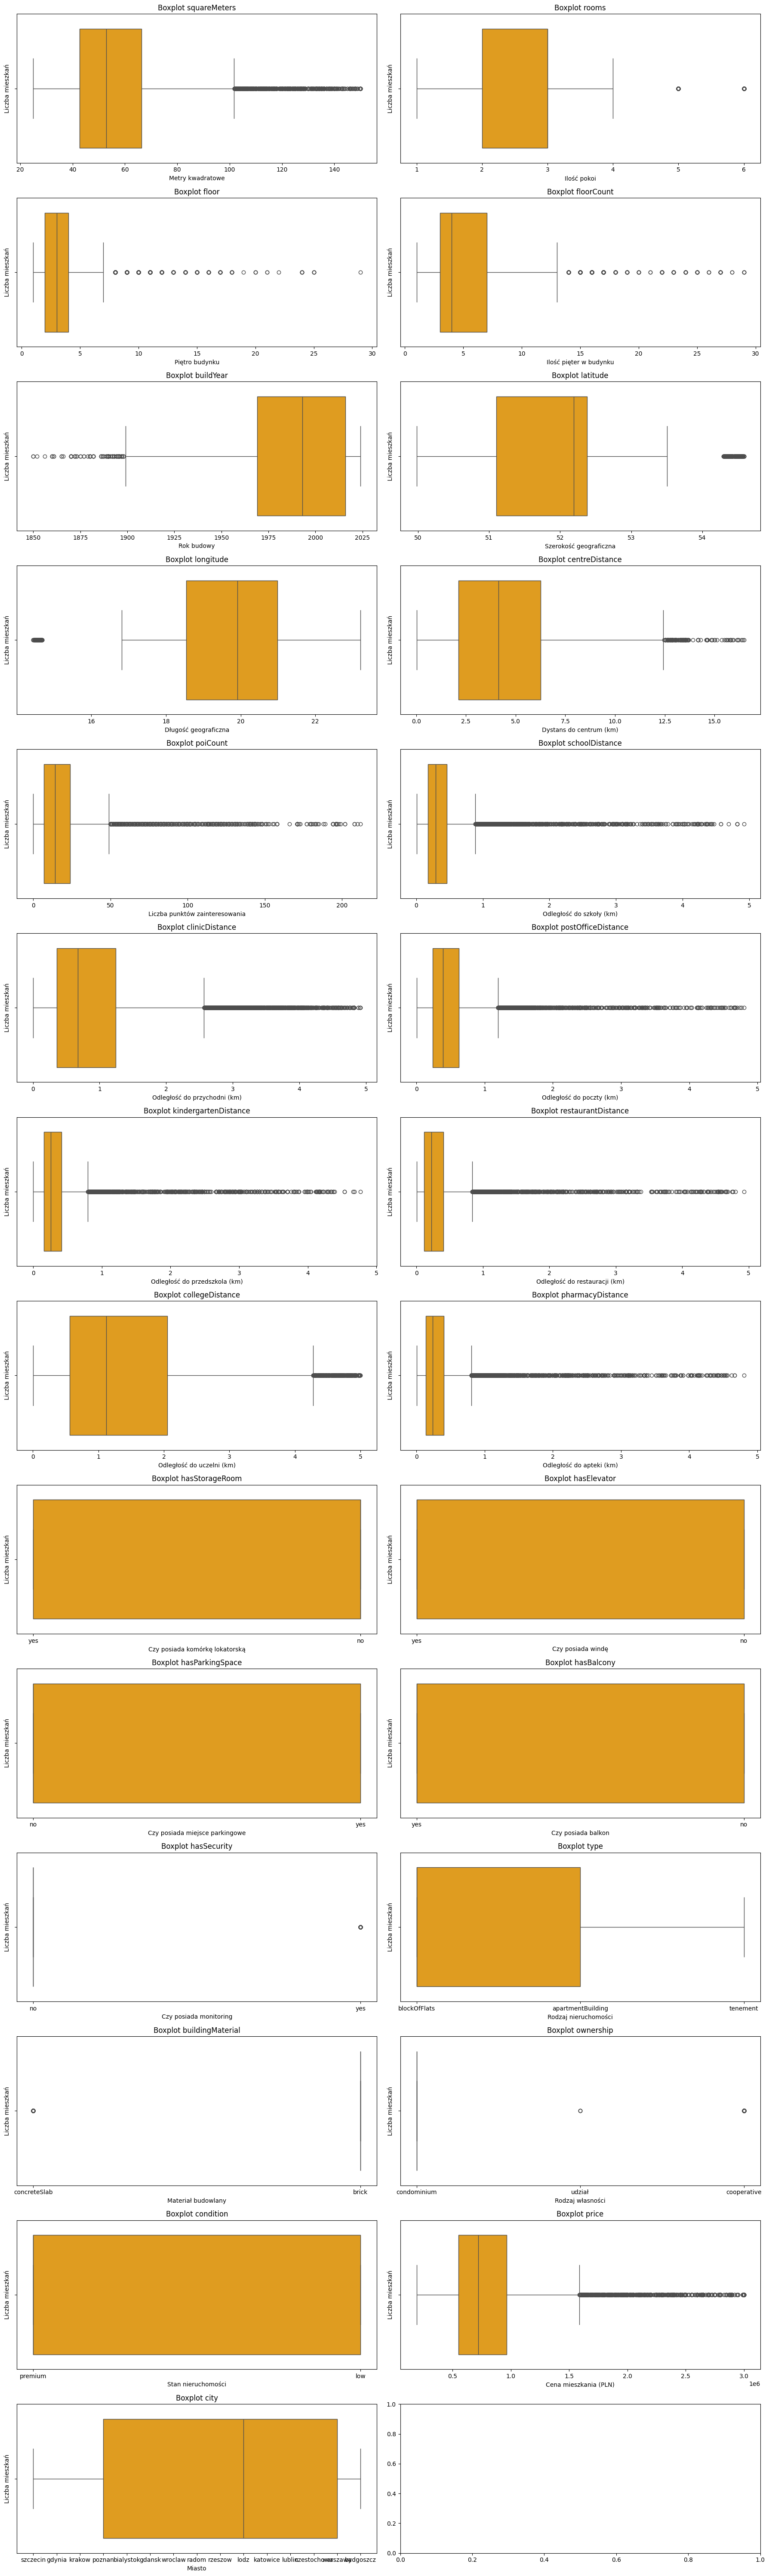

In [108]:
def create_box_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="orange"):
    sns.boxplot(data[column], color=color, ax=axes[index], orient='h')
    axes[index].set_title(f"Boxplot {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)


fig, axes = plt.subplots(14, 2, figsize=(18, 60))
axes = axes.flatten()

create_box_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_box_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi")
create_box_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_box_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_box_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_box_plot(5, apartments_data, "latitude", axes, xlabel="Szerokość geograficzna")
create_box_plot(6, apartments_data, "longitude", axes, xlabel="Długość geograficzna")
create_box_plot(7, apartments_data, "centreDistance", axes, xlabel="Dystans do centrum (km)")
create_box_plot(8, apartments_data, "poiCount", axes, xlabel="Liczba punktów zainteresowania")
create_box_plot(9, apartments_data, "schoolDistance", axes, xlabel="Odległość do szkoły (km)")
create_box_plot(10, apartments_data, "clinicDistance", axes, xlabel="Odległość do przychodni (km)")
create_box_plot(11, apartments_data, "postOfficeDistance", axes, xlabel="Odległość do poczty (km)")
create_box_plot(12, apartments_data, "kindergartenDistance", axes, xlabel="Odległość do przedszkola (km)")
create_box_plot(13, apartments_data, "restaurantDistance", axes, xlabel="Odległość do restauracji (km)")
create_box_plot(14, apartments_data, "collegeDistance", axes, xlabel="Odległość do uczelni (km)")
create_box_plot(15, apartments_data, "pharmacyDistance", axes, xlabel="Odległość do apteki (km)")
create_box_plot(16, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską")
create_box_plot(17, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę")
create_box_plot(18, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe")
create_box_plot(19, apartments_data, "hasBalcony", axes, xlabel="Czy posiada balkon")
create_box_plot(20, apartments_data, "hasSecurity", axes, xlabel="Czy posiada monitoring")
create_box_plot(21, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości")
create_box_plot(22, apartments_data, "buildingMaterial", axes, xlabel="Materiał budowlany")
create_box_plot(23, apartments_data, "ownership", axes, xlabel="Rodzaj własności")
create_box_plot(24, apartments_data, "condition", axes, xlabel="Stan nieruchomości")
create_box_plot(25, apartments_data, "price", axes, xlabel="Cena mieszkania (PLN)")
create_box_plot(26, apartments_data, "city", axes, xlabel="Miasto")

plt.tight_layout()
plt.show()



Wnioski z owych wykresów są tożsame z tymi spod histogramów.

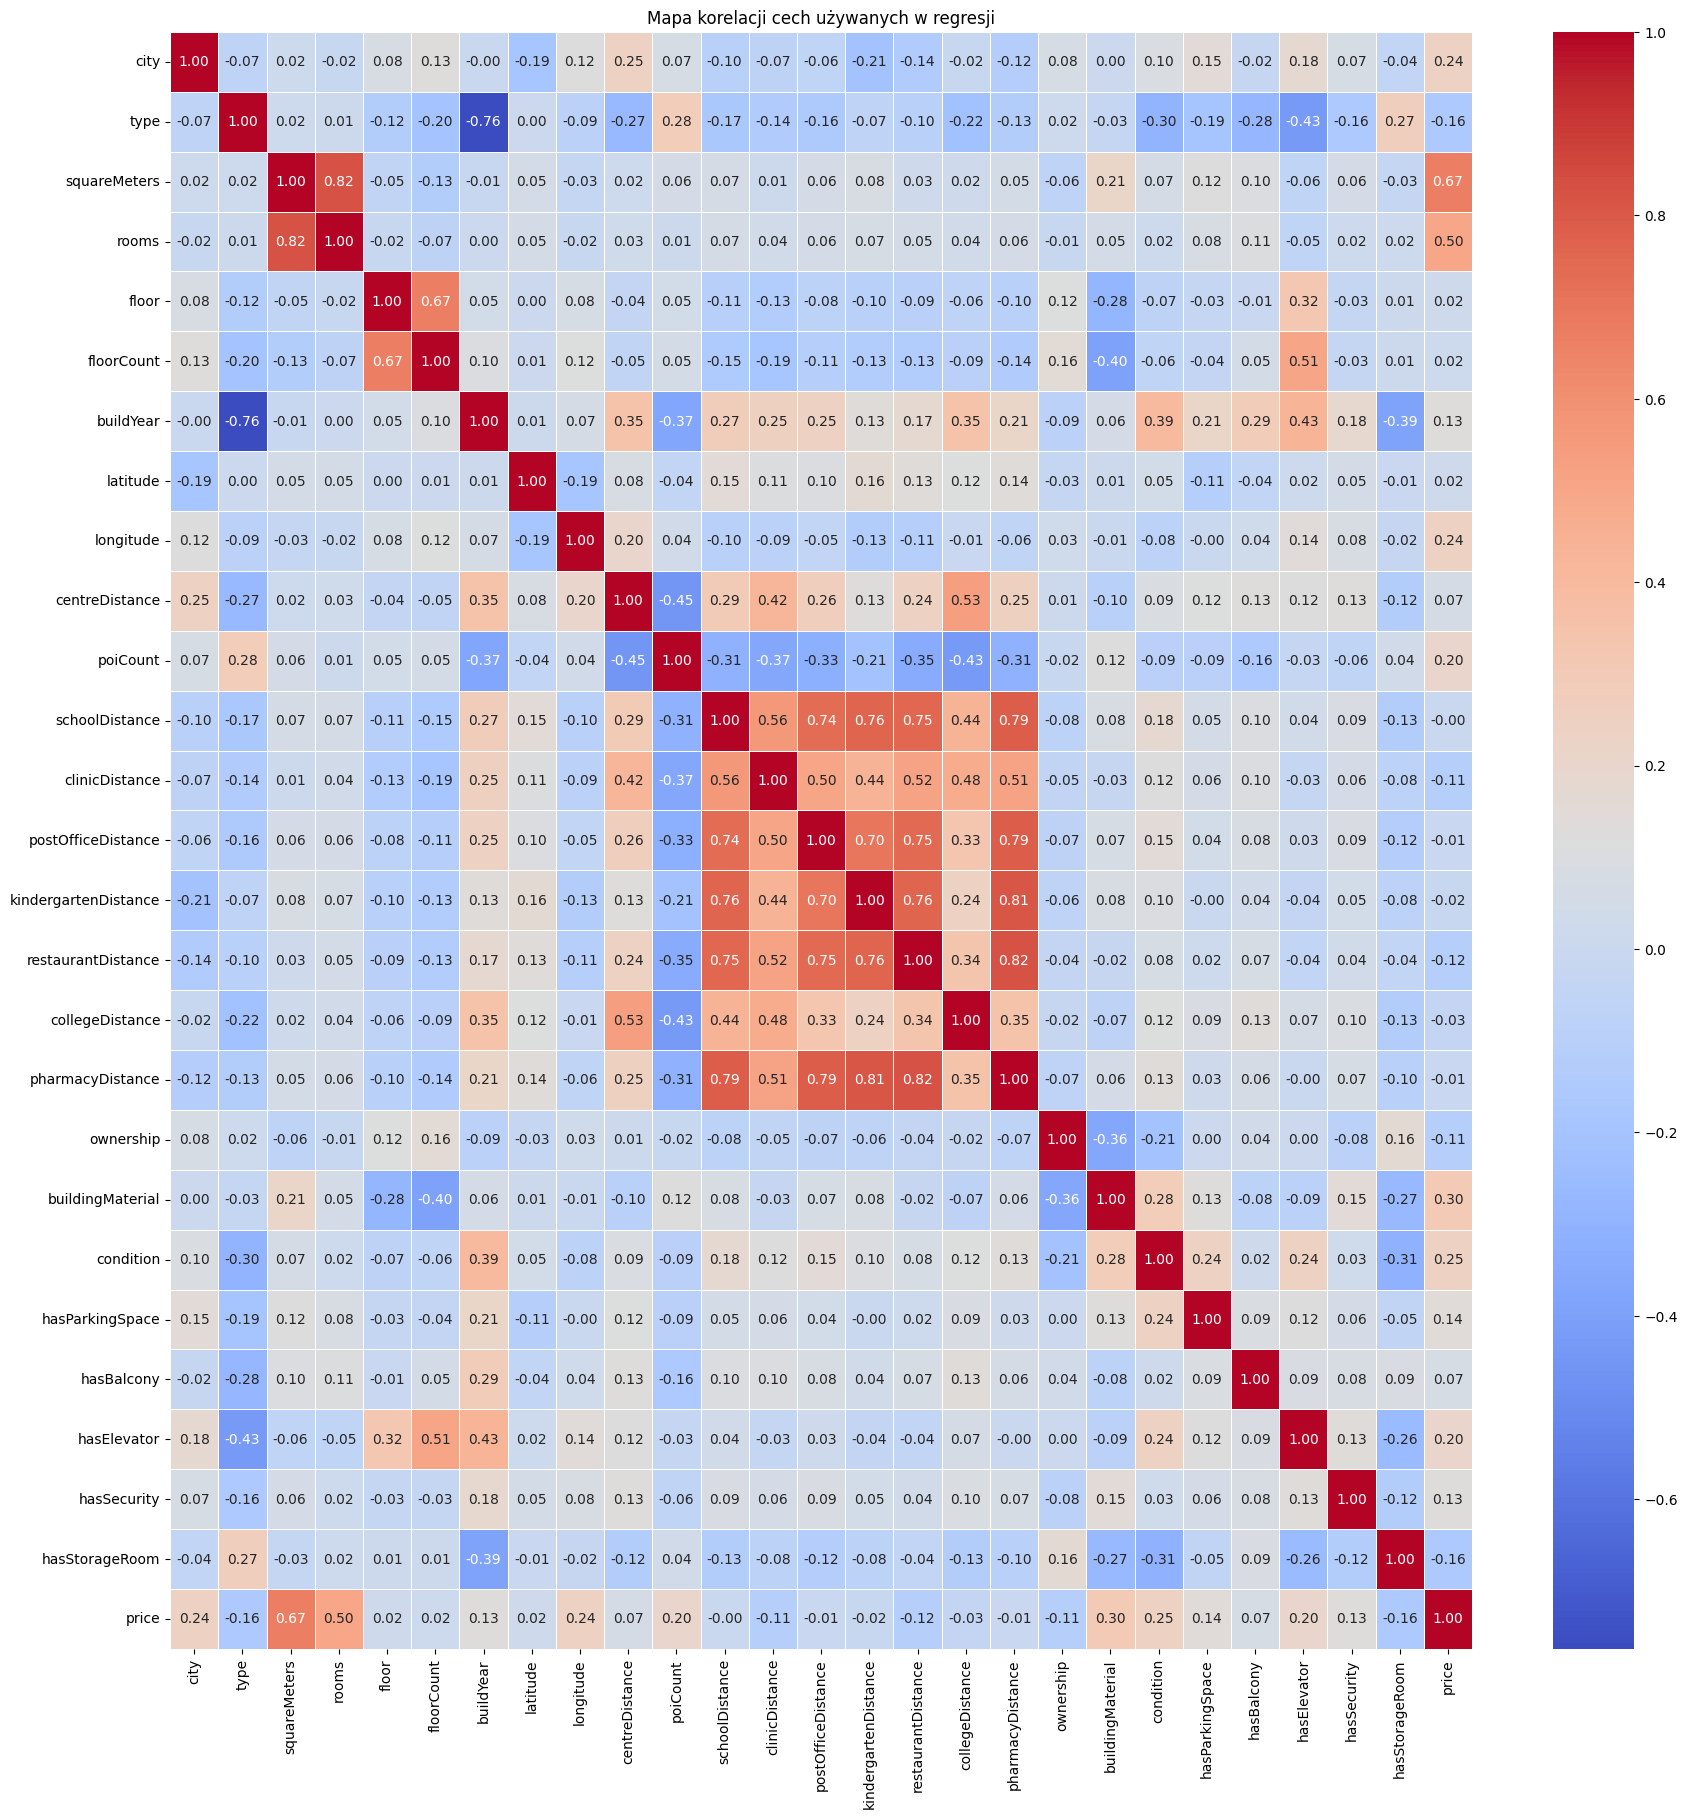

In [109]:
filtered_data = apartments_data[selected_columns].copy()

filtered_data["hasElevator"] = filtered_data["hasElevator"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasParkingSpace"] = filtered_data["hasParkingSpace"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["type"] = filtered_data["type"].map({"blockOfFlats": 1, "apartmentBuilding": 0, "tenement": 2}).astype(
    "Int64")
filtered_data["hasStorageRoom"] = filtered_data["hasStorageRoom"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["buildingMaterial"] = filtered_data["buildingMaterial"].map({"brick": 1, "concreteSlab": 0}).astype("Int64")
filtered_data["hasBalcony"] = filtered_data["hasBalcony"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasSecurity"] = filtered_data["hasSecurity"].map({"yes": 1, "no": 0}).astype("Int64")

filtered_data["ownership"] = filtered_data["ownership"].map({
    "condominium": 0,
    "cooperative": 1,
    "udział": 2
}).astype("Int64")

filtered_data["condition"] = filtered_data["condition"].map({
    "low": 0,
    "premium": 1
}).astype("Int64")

filtered_data["city"] = filtered_data["city"].astype("category").cat.codes

corr_matrix = filtered_data.corr(method='pearson')

plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

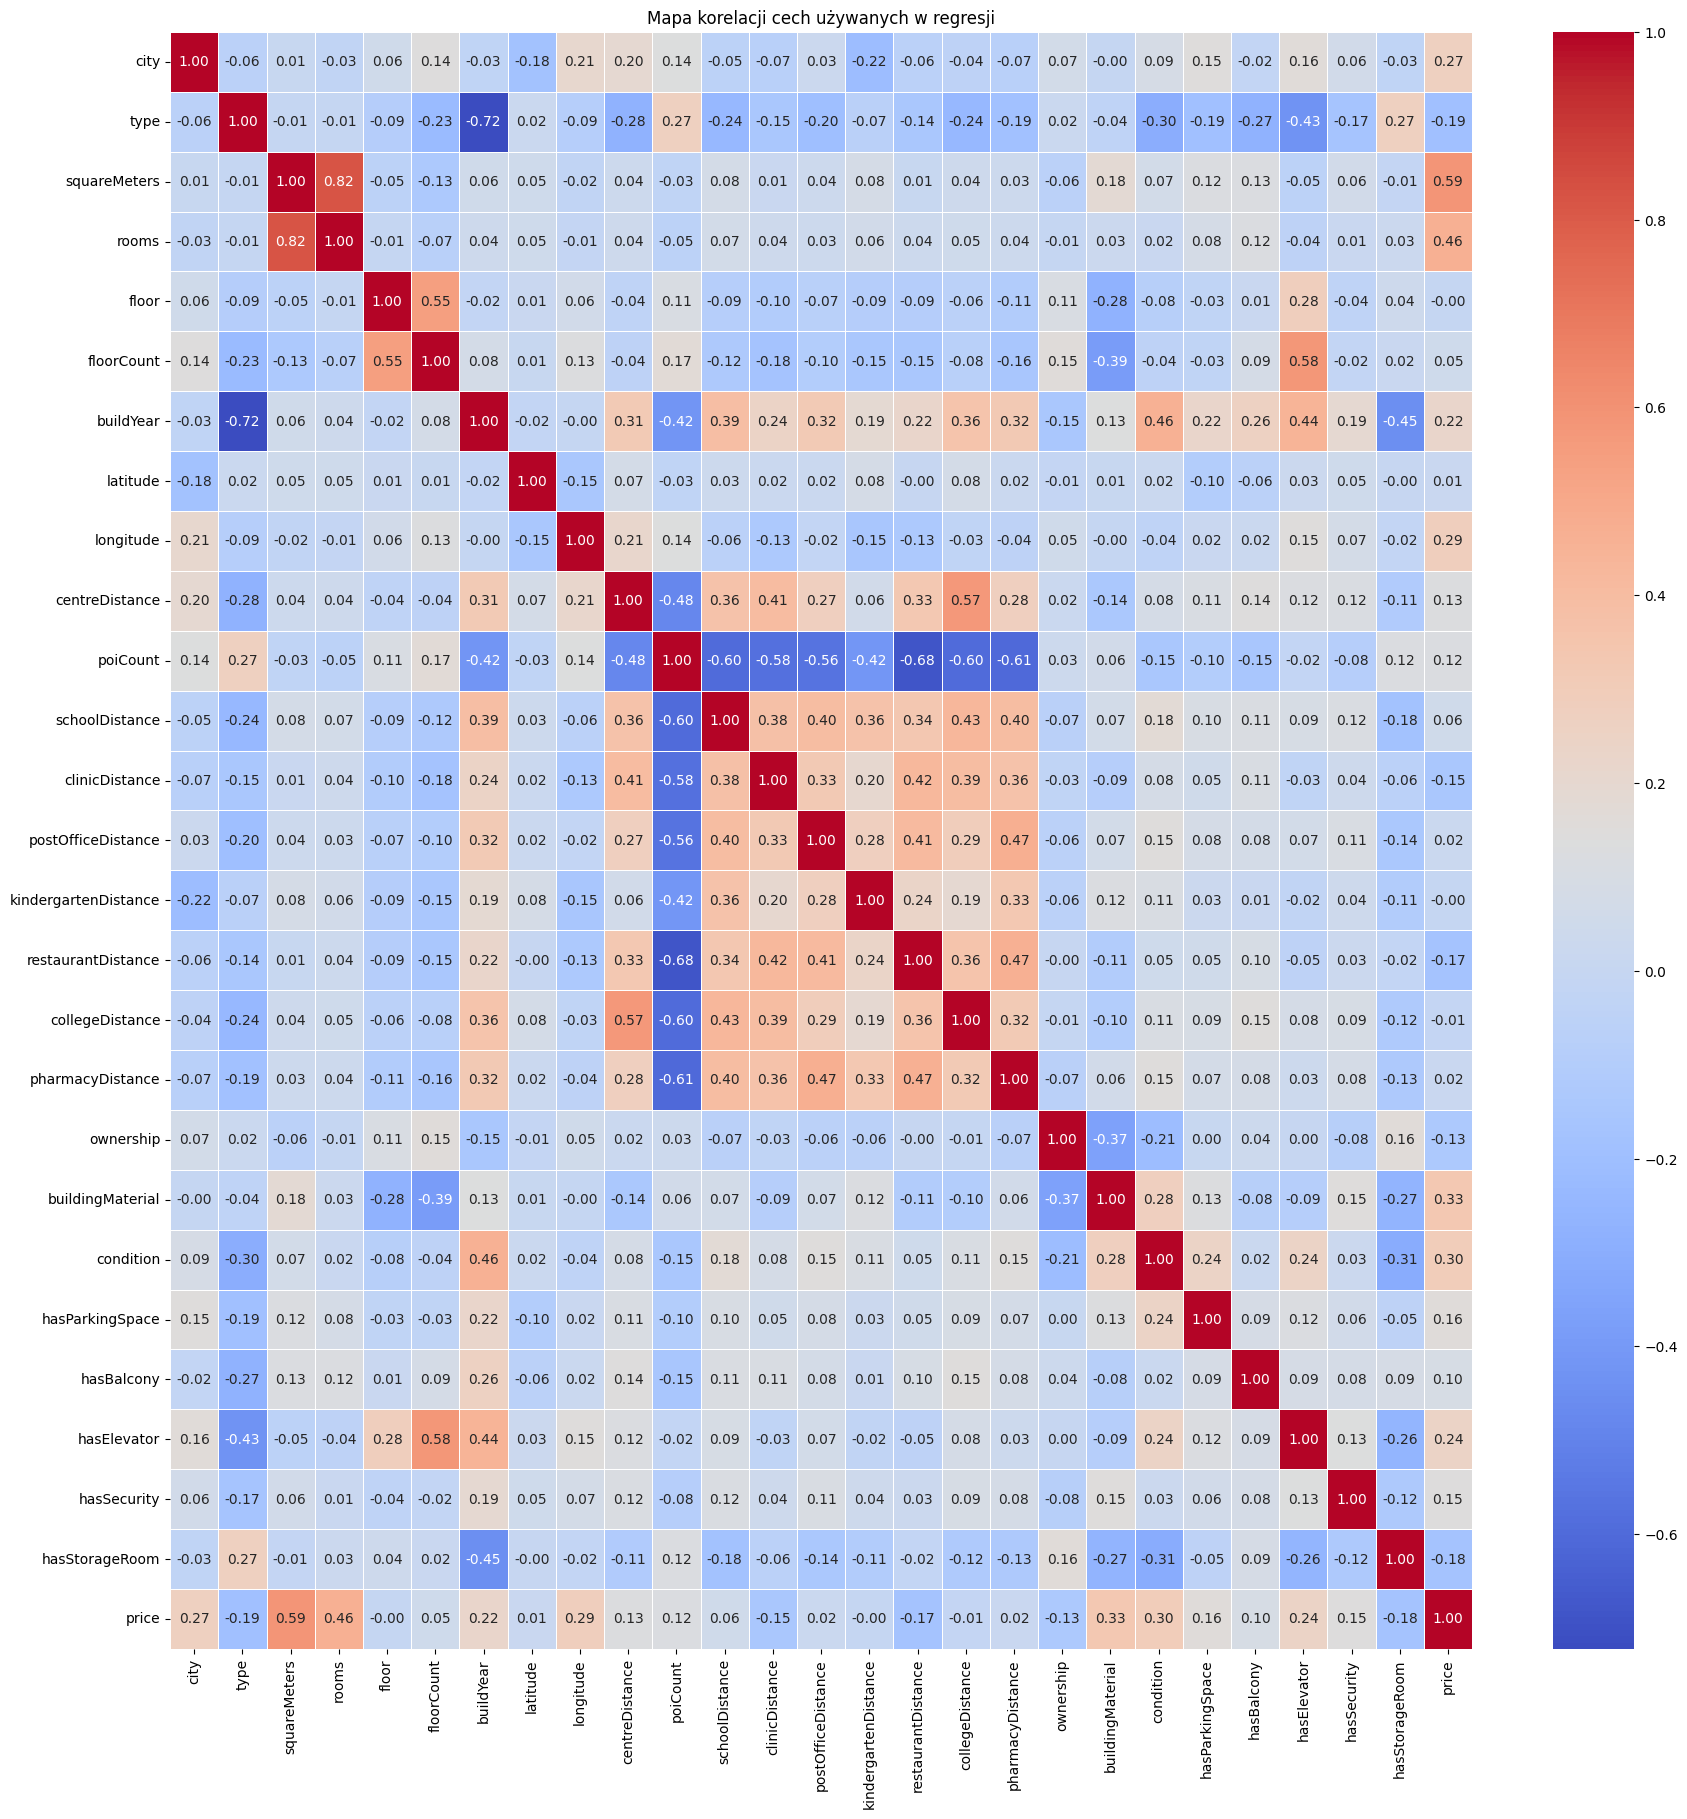

In [110]:
corr_matrix = filtered_data.corr(method='spearman')

plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

Wnioski:
1. Metraż i liczba pokoi - Najsilniejsza korelacja w obu metodach (Pearson: 0.82, Spearman: 0.82)
   - Zależność ta jest oczywista i potwierdza, że większe mieszkania posiadają więcej pokoi.

2. Metraż i cena - Bardzo silna korelacja (Pearson: 0.67, Spearman: 0.59)
   - Potwierdza, że powierzchnia mieszkania jest kluczowym czynnikiem wpływającym na jego cenę.

3. Liczba pięter w budynku i obecność windy - Silna korelacja (Pearson: 0.51, Spearman: 0.58)
   - Im wyższy budynek, tym większe prawdopodobieństwo, że posiada windę.

4. Piętro i liczba pięter w budynku - Silna korelacja (Pearson: 0.67, Spearman: 0.55)
   - Mieszkania na wyższych piętrach znajdują się częściej w wyższych budynkach.

5. Rok budowy i obecność windy - Wyraźna korelacja (Pearson: 0.43, Spearman: 0.44)
   - Nowsze budynki częściej wyposażone są w windy.

6. Liczba pokoi i cena - Znacząca korelacja (Pearson: 0.50, Spearman: 0.46)
   - Potwierdza wpływ liczby pokoi na cenę mieszkania.


In [111]:
avg_prices = apartments_data[['city', 'price']].copy().groupby('city')['price'].agg(['mean', 'count']).reset_index()

avg_prices.columns = ['City', 'Average Price', 'Number of properties']

avg_prices['Average Price'] = avg_prices['Average Price'].round(0).astype(int)

avg_prices = avg_prices.sort_values('Average Price', ascending=False)
avg_prices

,City,Average Price,Number of properties
13,warszawa,1053134,6962
6,krakow,942169,3245
3,gdansk,891338,1986
4,gdynia,884685,828
14,wroclaw,745965,2271
9,poznan,647102,793
11,rzeszow,636871,163
8,lublin,581739,574
12,szczecin,572549,647
5,katowice,528240,593


Jak można zauważyć na powyższym zestawieniu najwyższa średnia cena transakcyjna występuje w stolicy polski i wynosi: 1,053,134 pln. Na drugim miejscu plasuje się Kraków z średnią ceną niższą o 110 tys. pln niż Warszawa tj. 942,169 pln

In [112]:
import folium
from folium.plugins import HeatMap

cracow_df = apartments_data[apartments_data['city'] == 'krakow'].copy()

center_lat = cracow_df['latitude'].mean()
center_lng = cracow_df['longitude'].mean()

points = cracow_df[['latitude', 'longitude']].values.tolist()

cracow_map = folium.Map(location=[center_lat, center_lng], zoom_start=12)

HeatMap(points).add_to(cracow_map)

cracow_map

Mapa cieplna przedstawia geograficzny rozkład ofert nieruchomości w Krakowie, ukazując ich koncentrację w poszczególnych częściach miasta. Najwyższa gęstość ofert znajduje się w centrum, co wskazuje na duże zapotrzebowanie na nieruchomości w tej lokalizacji. Dzielnice takie jak Stare Miasto i Kazimierz cieszą się szczególną popularnością. Mniejsza liczba ofert na obrzeżach Krakowa wskazuje na niższe zainteresowanie lub ograniczoną podaż w tych rejonach.